## Setup

In [1]:
%matplotlib inline
from IPython.display import display

# External modules
import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
# Path management
from pathlib import Path

# Get main project directory 
main_dir = str(Path(os.path.abspath('')).parents[0])
os.chdir(main_dir)
print('main dir:',main_dir)

main dir: /Users/pablo/OneDrive/data-science/github/transportAI


In [3]:
# Internal modules
from src import isuelogit as isl

main dir: /Users/pablo/OneDrive/data-science/github/transportAI


In [4]:
# Global parameters for experiments
_BILEVEL_ITERS = 2
_REPLICATES = 2
_ALPHA = 0.1
_RANGE_INITIAL_VALUES = (-1,1)
_SD_X = 0.03
_ETA_NGD = 5e-1
_SCALE_OD = 1
_N_SPARSE_FEATURES = 6
_SEED = 2022
_SHOW_REPLICATE_PLOT = False
_REPLICATE_REPORT = False

In [5]:
# List of experiments
list_experiments  = ['pseudoconvexity', 'convergence','congestion','consistency', 'irrelevant_attributes',
                     'noisy_counts','sensor_coverage','noisy_od','ill_scaled_od']

run_experiment = dict.fromkeys(list_experiments,True)
# run_experiment = dict.fromkeys(list_experiments,False)

# run_experiment['pseudoconvexity'] = True
# run_experiment['convergence'] = True
# run_experiment['congestion'] = True
# run_experiment['consistency'] = True
# run_experiment['irrelevant_attributes'] = True
# run_experiment['sensor_coverage'] = True
# run_experiment['noisy_counts'] = True
run_experiment['noisy_od'] = True
run_experiment['ill_scaled_od'] = True

## Read network data from tntp repository

In [6]:
network_name = 'SiouxFalls'

# Read input data files
links_df = isl.reader.read_tntp_linkdata(network_name= network_name)

# Add link key
links_df['link_key'] = [(i, j, '0') for i, j in zip(links_df['init_node'], links_df['term_node'])]

## Build network

In [7]:
network_generator = isl.factory.NetworkGenerator()

A = network_generator.generate_adjacency_matrix(links_keys = list(links_df['link_key'].values))

tntp_network = network_generator.build_network(A = A,network_name= network_name)


Creating SiouxFalls network

Nodes: 24, Links: 76


### Exogenous link attributes

In [8]:
# Extract data on link features
link_features_df = links_df[['link_key', 'speed', 'toll', 'link_type']]

#Load features data
tntp_network.load_features_data(linkdata = link_features_df)

### Link performance functions

In [9]:
# Create BPR functions among links using parameters read from TNTP file
bpr_parameters_df = pd.DataFrame({'link_key': tntp_network.links_dict.keys(),
                                  'alpha': links_df.b,
                                  'beta': links_df.power,
                                  'tf': links_df.free_flow_time,
                                  'k': links_df.capacity
                                  })

# Normalize free flow travel time between 0 and 1
bpr_parameters_df['tf'] = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(np.array(bpr_parameters_df['tf']).reshape(-1, 1)))

tntp_network.set_bpr_functions(bprdata = bpr_parameters_df)

### OD matrix

In [10]:
# Read od matrix
Q = isl.reader.read_tntp_od(network_name= network_name)

# Load O-D matrix
tntp_network.load_OD(Q  = Q)

Reading Q from external file
Matrix Q (24, 24) read in 0.0[s]
360600.0 trips were loaded among 528 o-d pairs


### Paths

In [11]:
# Create path generator
paths_generator = isl.factory.PathsGenerator()

# Generate and Load paths in network
paths_generator.load_k_shortest_paths(network = tntp_network, k=3)

Generating at most 3 paths per od
1584 paths were generated among 528 od pairs in 0.3 [s]
1584 paths were loaded in the network
Updating incidence matrices
Matrix D (76, 1584) generated in 0.2[s].0% 
Matrix M (528, 1584) generated in 0.1[s]0% 
Matrix C (1584, 1584) generated in 0.0[s]


### Equilibrator

In [12]:
equilibrator = isl.equilibrium.LUE_Equilibrator(
    network = tntp_network,
    max_iters=100,
    method='fw',
    iters_fw=100,
    accuracy=1e-10,
    # uncongested_mode = True,
    exogenous_traveltimes=True,
    paths_generator=paths_generator,
    path_size_correction=1
)

### Utility Function

In [13]:
utility_function = isl.estimation.UtilityFunction(features_Y=['tt'],
                                                  features_Z=['c', 's'],
                                                  true_values={'tt': -1, 'c': -6, 's': -3})

## Descriptive statistics

### Network topology

In [14]:
isl.descriptive_statistics.summary_table_networks([tntp_network])

,network,nodes,links,ods,paths
0,SiouxFalls,24,76,528,1584


### Links data

In [15]:
display(tntp_network.Z_data)

,link_type,speed,toll,alpha,beta,tf,k
0,1,0,0,0.15,4.0,0.500,25900.200640
1,1,0,0,0.15,4.0,0.250,23403.473190
2,1,0,0,0.15,4.0,0.500,25900.200640
3,1,0,0,0.15,4.0,0.375,4958.180928
4,1,0,0,0.15,4.0,0.250,23403.473190
...,...,...,...,...,...,...,...
71,1,0,0,0.15,4.0,0.250,5000.000000
72,1,0,0,0.15,4.0,0.000,5078.508436
73,1,0,0,0.15,4.0,0.250,5091.256152
74,1,0,0,0.15,4.0,0.125,4885.357564


In [16]:
tntp_network.Z_data.describe()

,link_type,speed,toll,alpha,beta,tf,k
count,76.0,76.0,76.0,76.00,76.0,76.000000,76.000000
mean,1.0,0.0,0.0,0.15,4.0,0.266447,10247.206327
std,0.0,0.0,0.0,0.00,0.0,0.216354,7358.655049
min,1.0,0.0,0.0,0.15,4.0,0.000000,4823.950831
25%,1.0,0.0,0.0,0.15,4.0,0.125000,4958.180928
50%,1.0,0.0,0.0,0.15,4.0,0.250000,5109.391136
75%,1.0,0.0,0.0,0.15,4.0,0.375000,14564.753150
max,1.0,0.0,0.0,0.15,4.0,1.000000,25900.200640


## Experiments

### a) Pseudoconvexity


Generating synthetic link counts via Frank-Wolfe

SUE via fw (max iters: 0)
Ratio of counts versus capacity: 113.3%
Proportion of links over capacity: 63.2%
Normalized RMSE: 0.0

Performing grid search for tt

Progress: |████████████████████| 100.0% 

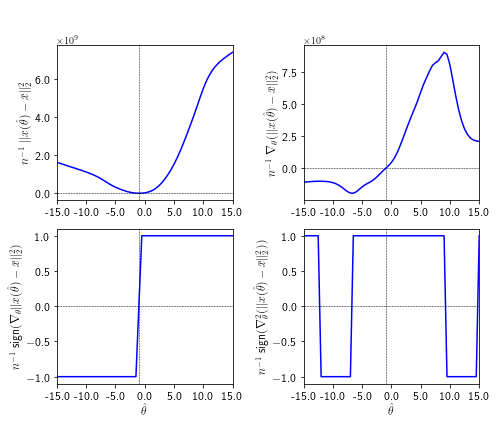


Performing grid search for c

Progress: |████████████████████| 100.0% 

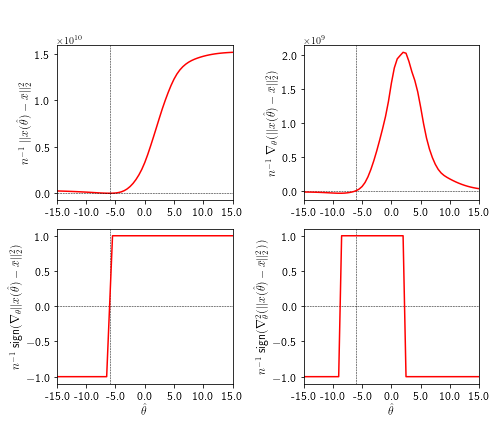

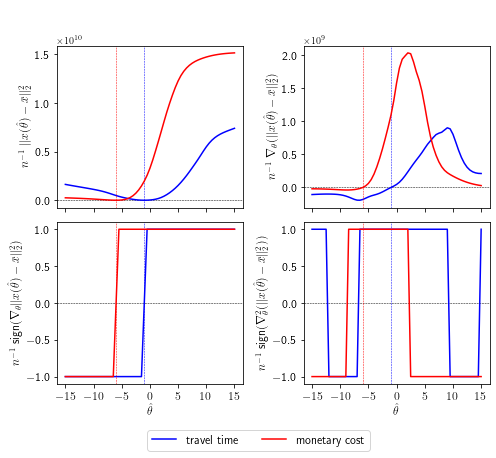

In [17]:
if run_experiment['pseudoconvexity']:

    pseudoconvexity_experiment = isl.experiments.PseudoconvexityExperiment(
        seed=_SEED,
        name='Pseudo-convexity Experiment',
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': 0*_SD_X}),
        equilibrator=isl.equilibrium.LUE_Equilibrator(paths_generator = paths_generator, uncongested_mode=True),
        network=tntp_network)

    # Generate new random features ('c,'s') and load them in the network
    tntp_network.load_features_data(linkdata=pseudoconvexity_experiment.generate_random_link_features(n_sparse_features=0))

    pseudoconvexity_experiment.run(grid = np.arange(-15, 15+0.1, 0.5),
                                   xticks=np.arange(-15, 15 + 0.1, 5),
                                   features=['tt', 'c'],
                                   features_labels = ['travel time', 'monetary cost'],
                                   colors = ['blue','red']
                                   )

### b) Convergence


Convergence Experiment

Scenario: uncongested

Generating synthetic link counts via Frank-Wolfe

SUE via fw (max iters: 0)
Performed path size correction with factor 1
Ratio of counts versus capacity: 113.5%
Proportion of links over capacity: 63.2%
Normalized RMSE: 0.0

Statistical Inference in No Refined Stage

Bilevel optimization for SiouxFalls network 

Initial theta: {'tt': '0.0E+00', 'c': '0.0E+00', 's': '0.0E+00'}
Initial objective: 4,436,428,601
Initial RMSE: 7640.3
Initial Normalized RMSE: 0.657

Iterations: |████████████████████| 10/10
Summary results of bilevel optimization
best iter: 10
best theta: {'tt': '-2.2E-01', 'c': '-6.7E-01', 's': '-5.4E-01'}
best ratio theta: 0.321
best objective_value: 1,245,173,348
Final best objective improvement: 71.93%
Final best objective improvement value: 3,191,255,253.1
Best RMSE: 4047.7
Best Normalized RMSE: 0.348
Total time: 4.0 [s]

Performing hypothesis testing (H0: theta = 0, alpha = 0.05)
Hessian approximated as J^T J

Summary of pa

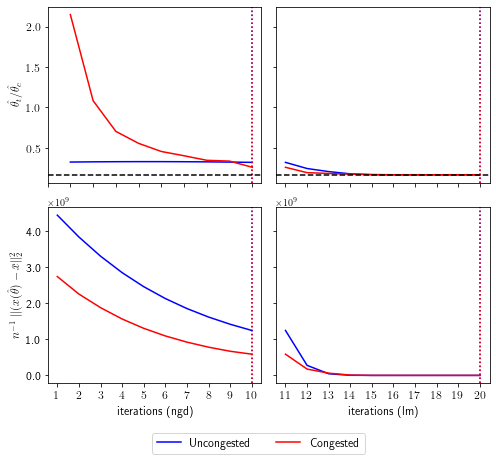

In [18]:
if run_experiment['convergence']:

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta=_ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1,
    )

    convergence_experiment = isl.experiments.ConvergenceExperiment(
        seed=_SEED,
        name='Convergence Experiment',
        outer_optimizers=[outer_optimizer_norefined, outer_optimizer_refined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': 0*_SD_X}),
        equilibrator=equilibrator,
        bilevel_iters=_BILEVEL_ITERS,
        network=tntp_network)

    # Generate new random features ('c,'s') and load them in the network
    tntp_network.load_features_data(
        linkdata=convergence_experiment.generate_random_link_features(
        n_sparse_features=0))

    convergence_experiment.run(range_initial_values = None, replicate_report = False)

### c) Consistency


Consistency Experiment
Replicates: |████████████████████| 100/100


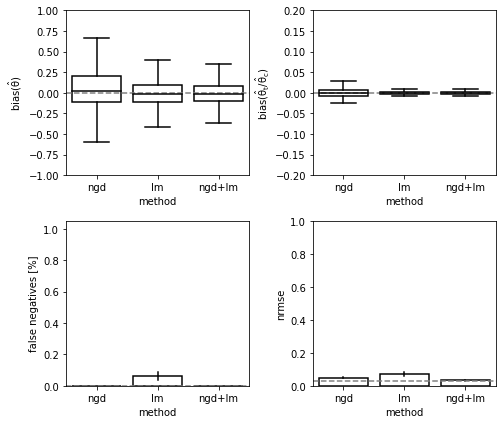

In [19]:
if run_experiment['consistency']:

    outer_optimizer_no_refined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta= _ETA_NGD
    )

    outer_optimizer_refined_1 = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1
    )

    outer_optimizer_refined_2 = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1
    )

    consistency_experiment = isl.experiments.ConsistencyExperiment(
        seed=_SEED,
        name='Consistency Experiment',
        equilibrator=equilibrator,
        outer_optimizers=[outer_optimizer_no_refined,
                          outer_optimizer_refined_1,
                          outer_optimizer_refined_2],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        network=tntp_network)

    # Note: Random features ('c,'s') are generated and loaded in the network at every replicate
    consistency_experiment.run(
        bilevel_iters = _BILEVEL_ITERS,
        range_initial_values = _RANGE_INITIAL_VALUES,
        replicates = _REPLICATES,
        n_sparse_features=0*_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        replicate_report = False,
        alpha = _ALPHA
    )

### d) Inclusion of irrelevant attributes


Irrelevant Attributes Experiment
Replicates: |████████████████████| 100/100


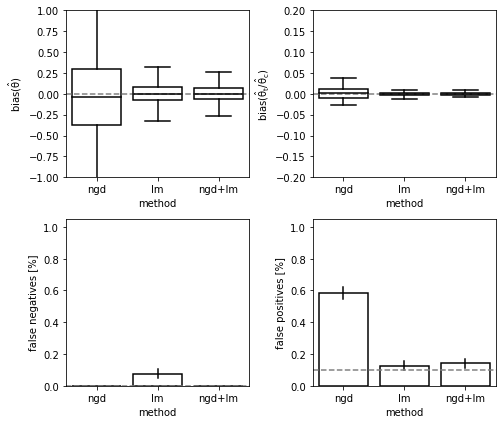

In [20]:
if run_experiment['irrelevant_attributes']:

    outer_optimizer_no_refined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta=_ETA_NGD
    )

    outer_optimizer_refined_1 = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1
    )

    outer_optimizer_refined_2 = isl.estimation.OuterOptimizer(
        method='lm',
        iters=1
    )

    irrelevant_attributes_experiment = isl.experiments.ConsistencyExperiment(
        seed=_SEED,
        name='Irrelevant Attributes Experiment',
        equilibrator=equilibrator,
        outer_optimizers=[outer_optimizer_no_refined,
                          outer_optimizer_refined_1,
                          outer_optimizer_refined_2],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        network=tntp_network)

    # Note: Random features ('c,'s') and 3 sparse attributes are generated and loaded in the network at every replicate

    irrelevant_attributes_experiment.run(
        bilevel_iters=_BILEVEL_ITERS,
        range_initial_values=_RANGE_INITIAL_VALUES,
        replicates=_REPLICATES,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        replicate_report = False,
        alpha=_ALPHA
    )

### e) Error in traffic count measurements


Noisy Counts Experiment


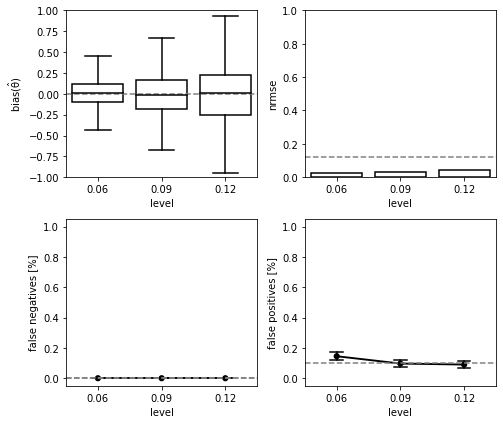

In [21]:
if run_experiment['noisy_counts']:

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta= _ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        iters=1,
        method='lm',
        #method='ngd',
        #eta=_ETA_NGD
    )

    noisy_counts_experiment = isl.experiments.CountsExperiment(
        seed=_SEED,
        name='Noisy Counts Experiment',
        outer_optimizers= [outer_optimizer_norefined, outer_optimizer_refined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(),
        equilibrator=equilibrator,
        bilevel_iters= _BILEVEL_ITERS,
        network=tntp_network)

    # Note: Random features ('c,'s') and 3 sparse attributes are generated and loaded in the network at every replicate

    noisy_counts_experiment.run(
        replicates = _REPLICATES,
        range_initial_values = _RANGE_INITIAL_VALUES,
        alpha = _ALPHA,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        levels = [0.06,0.09,0.12],
        type = 'noise')

### f) Sensor coverage


Sensor Coverage Experiment


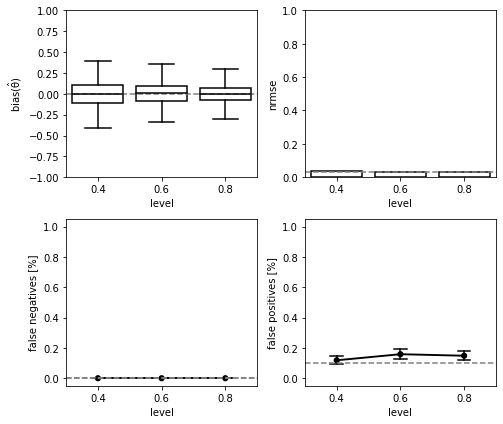

In [22]:
if run_experiment['sensor_coverage']:

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta= _ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        iters=1,
        method='lm',
        #method='ngd',
        #eta=_ETA_NGD
    )

    sensor_coverage_experiment = isl.experiments.CountsExperiment(
        seed=_SEED,
        name='Sensor Coverage Experiment',
        outer_optimizers=[outer_optimizer_norefined, outer_optimizer_refined],
        # outer_optimizers=[outer_optimizer_norefined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        equilibrator=equilibrator,
        bilevel_iters=_BILEVEL_ITERS,
        network=tntp_network)

    # Note: Random features ('c,'s') and 3 sparse attributes are generated and loaded in the network at every replicate
    sensor_coverage_experiment.run(
        alpha = _ALPHA,
        replicates = _REPLICATES,
        range_initial_values = _RANGE_INITIAL_VALUES,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        replicate_report = False,
        # levels=[0.25, 0.5, 0.75, 1.0],
        # levels=[0.25, 0.5, 0.75],
        levels=[0.4, 0.6, 0.8],
        type = 'coverage')

### g) Error in OD matrix


Noisy OD Experiment
Replicates: |████████████████████| 100/100


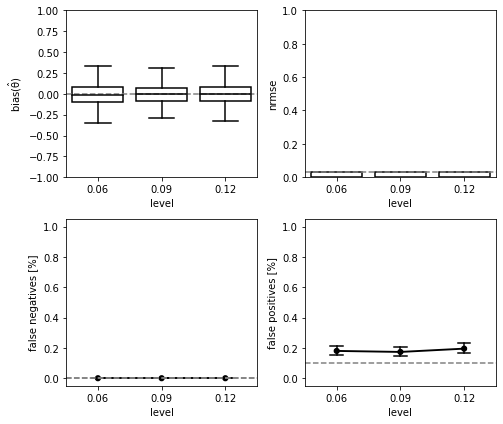

In [23]:
if run_experiment['noisy_od']:

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta= _ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        iters=1,
        method='lm',
        #method='ngd',
        #eta=_ETA_NGD
    )

    noisy_od_experiment = isl.experiments.ODExperiment(
        seed=_SEED,
        name='Noisy OD Experiment',
        outer_optimizers=[outer_optimizer_norefined, outer_optimizer_refined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        equilibrator=equilibrator,
        bilevel_iters=_BILEVEL_ITERS,
        network=tntp_network)

    # Note: Random features ('c,'s') and 3 sparse attributes are generated and loaded in the network at every replicate

    noisy_od_experiment.run(
        replicates = _REPLICATES,
        range_initial_values = _RANGE_INITIAL_VALUES,
        levels=[0.06, 0.09, 0.12],
        alpha=_ALPHA,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        type = 'noise')

### h) Scale of OD matrix

In [ ]:
if run_experiment['ill_scaled_od']:

    outer_optimizer_norefined = isl.estimation.OuterOptimizer(
        method='ngd',
        iters=1,
        eta=_ETA_NGD
    )

    outer_optimizer_refined = isl.estimation.OuterOptimizer(
        iters=1,
        method='lm',
        #method='ngd',
        #eta=_ETA_NGD
    )

    ill_scaled_od_experiment = isl.experiments.ODExperiment(
        seed=_SEED,
        name='Ill-scaled OD Experiment',
        outer_optimizers=[outer_optimizer_norefined, outer_optimizer_refined],
        utility_function=utility_function,
        linkdata_generator=isl.factory.LinkDataGenerator(noise_params={'sd_x': _SD_X}),
        equilibrator=equilibrator,
        bilevel_iters=_BILEVEL_ITERS,
        network=tntp_network)

    # Note: Random features ('c,'s') and 3 sparse attributes are generated and loaded in the network at every replicate

    ill_scaled_od_experiment.run(
        replicates = _REPLICATES,
        range_initial_values = _RANGE_INITIAL_VALUES,
        alpha = _ALPHA,
        n_sparse_features=_N_SPARSE_FEATURES,
        show_replicate_plot=_SHOW_REPLICATE_PLOT,
        levels = [0.96,0.98,1.02,1.04],
        # levels=[0.90, 0.95, 1.05, 1.10],
        type = 'scale')


Ill-scaled OD Experiment
